In [1]:
import pandas as pd
import numpy as np
import csv

## Define some paths and load files

In [126]:
original_label_path = "/Users/kiyoshi/Desktop/msdn_results/0807_0809/369_k_plus_1/original_labels.npy"
target_label_path = "/Users/kiyoshi/Desktop/msdn_results/0807_0809/369_k_plus_1/targets.npy"
prob_path = "/Users/kiyoshi/Desktop/msdn_results/0807_0809/369_k_plus_1/probs.npy"
rt_path = "/Users/kiyoshi/Desktop/msdn_results/0807_0809/369_k_plus_1/rts.npy"

In [ ]:
original_label_path = "/Users/kiyoshi/Desktop/msdn_results/0807_0809/369_k_plus_1/original_labels.npy"
target_label_path = "/Users/kiyoshi/Desktop/msdn_results/0807_0809/369_k_plus_1/targets.npy"
prob_path = "/Users/kiyoshi/Desktop/msdn_results/0807_0809/369_k_plus_1/probs.npy"
rt_path = "/Users/kiyoshi/Desktop/msdn_results/0807_0809/369_k_plus_1/rts.npy"

In [127]:
original_labels = np.load(original_label_path)
target_labels = np.load(target_label_path)
probs = np.load(prob_path)
rts = np.load(rt_path)

In [128]:
print("There are %d test samples." % len(target_labels))

There are 43850 test samples.


In [144]:
rts.shape

(43850, 5)

In [145]:
rts[0]

array([0.36520918, 0.47854429, 0.58382382, 0.70495211, 0.7959425 ])

In [146]:
rts[0][4]

0.7959424979053438

In [147]:
rts[0, 4]

0.7959424979053438

## Get stats from the network output

In [129]:
def get_exit_stats(original_labels,
                   target_labels,
                   probs,
                   rts,
                   top_k=5,
                   nb_clfs=5,
                   top_1_threshold=0.90,
                   top_3_threshold=0.75,
                   top_5_threshold=0.70,
                   nb_training_classes=369):
    """
    
    
    """
    
    known_exit = []
    known_rts = []
    
    unknown_exit = []
    unknown_rts = []
    
    predictions = []
    
    
#     for i in range(len(original_labels)):
    for i in range(3):
        # Get eveything we need for a test sample first
        original_label = original_labels[i]
        target_label = target_labels[i]
        prob = probs[i]
        rt = rts[i]
        
        # check each classifier in order and decide when to exit
        for j in range(nb_clfs):
            one_prob = prob[j]
            pred = np.argmax(one_prob)
            max_prob = np.sort(one_prob)[-1]
            
            # If this is not the last classifier 
            if j != nb_clfs-1:
                # Only consider top-1 if it is not the last classifier
                if max_prob > top_1_threshold:
                    predictions.append(pred)
                    
                    if original_label < nb_training_classes-1:
                        known_exit.append(j)
                        known_rts.append(rt[j])
                    elif original_label >= nb_training_classes-1:
                        unknown_exit.append(j)
                        unknown_rts.append(rt[j])
                    
                    # If top-1 is larger than threshold,
                    # then directly go to next sample
                    break
                    
                else:
                    continue
             
            # If this is the last classifier
            else:
                # TODO: May need to update to top-k, but do top-1 first
                # Get the top-k in decreasing order
                #index = np.argpartition(prob, -top_k)[-top_k:]
                #ind_top_k = np.flipud(index[np.argsort(prob[index])])
                
                
                # Only consider top-1 now...
                if max_prob > top_1_threshold:
                    predictions.append(pred)
                   
                # If the probability is smaller than threshold for the last classifier,
                # reject the sample as unknow
                else:
                    predictions.append(-1)
                    
                if original_label < nb_training_classes-1:
                    known_exit.append(j)
                    known_rts.append(rt[j])
                else:
                    unknown_exit.append(j)
                    unknown_rts.append(rt[j])
                    
    return known_exit, known_rts, unknown_exit, unknown_rts, predictions
        
    
    

In [130]:
known_exit, known_rts, unknown_exit, unknown_rts, predictions = get_exit_stats(original_labels=original_labels,
                                                                                target_labels=target_labels,
                                                                                probs=probs,
                                                                                rts=rts)

## Count where the samples exit

In [131]:
import matplotlib.pyplot as plt

In [132]:
known_exit_count = np.unique(np.array(known_exit), return_counts=True)

In [133]:
known_exit_count[1]

array([ 8378,  4394,  2269,  1154, 23155])

<BarContainer object of 5 artists>

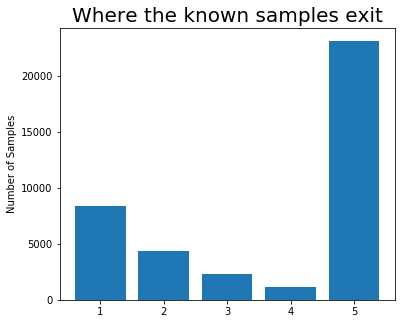

In [134]:
fig, ax = plt.subplots(figsize=(6, 5))
ax.set_ylabel('Number of Samples', fontsize=10)
ax.set_title('Where the known samples exit', fontsize=20)

ax.bar(known_exit_count[0]+1, height=known_exit_count[1])

In [135]:
unknown_exit_count = np.unique(np.array(unknown_exit), return_counts=True)

<BarContainer object of 5 artists>

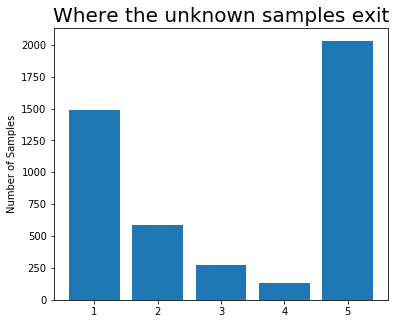

In [136]:
fig, ax = plt.subplots(figsize=(6, 5))
ax.set_ylabel('Number of Samples', fontsize=10)
ax.set_title('Where the unknown samples exit', fontsize=20)

ax.bar(unknown_exit_count[0]+1, height=unknown_exit_count[1])

## Count the CM for known and unknown

In [137]:
known_pred = predictions[:len(known_exit)]
known_target = target_labels[:len(known_exit)]

unknown_pred = predictions[len(known_exit):]
unknown_target = target_labels[len(known_exit):]

In [138]:
known_known = 0
known_unknow = 0
unknown_known = 0
unknown_unknown = 0

for i in range(len(known_pred)):
    if known_pred[i] != -1:
        known_known += 1
    else:
        known_unknow += 1
        
for i in range(len(unknown_pred)):
    if unknown_pred[i] != -1:
        unknown_known += 1
    else:
        unknown_unknown += 1
        
print(known_known, known_unknow, unknown_known, unknown_unknown)

17314 22036 2604 1896


## Get stats for reaction time (RT)

In [139]:
known_rts_clf5 = rts[:len(known_exit), 4]
unknown_rts_clf = rts[len(known_exit):, 4]

In [140]:
print(np.median(known_rts_clf5),np.median(unknown_rts_clf))

0.031583916395902634 0.031575437635183334


In [141]:
print(np.mean(known_rts_clf5),np.mean(unknown_rts_clf))

0.035213175434429846 0.035152573386828104


In [142]:
print(np.median(known_rts),np.median(unknown_rts))

0.03018316556699574 0.028374167624861002


In [143]:
print(np.mean(known_rts),np.mean(unknown_rts))

0.02825355204195021 0.02523685448596047


## Get acc for this result

In [148]:
known_correct = 0
known_wrong = 0

unknown_correct = 0
unknown_wrong = 0

for i in range(len(known_pred)):
    gt = known_target[i]
    pred = known_pred[i]
    
    if gt == pred:
        known_correct +=1
    else:
        known_wrong += 1
        
for i in range(len(unknown_pred)):
    gt = unknown_target[i]
    pred = unknown_pred[i]
    
    if gt == pred:
        unknown_correct +=1
    else:
        unknown_wrong += 1        
    
print(known_correct, known_wrong, unknown_correct, unknown_wrong)

16360 22990 1830 2670


In [150]:
known_acc = (known_correct/(known_correct+known_wrong))
unknown_acc = (unknown_correct/(unknown_correct+unknown_wrong))

In [152]:
print(known_acc, unknown_acc)

0.41575603557814483 0.4066666666666667
